# Search-Based Fuzzing

Sometimes we are not only interested in fuzzing as many as possible diverse program inputs, but in deriving *specific* test inputs that achieve some objective, such as reaching specific statements in a program. When we have an idea of what we are looking for, then we can *search* for it. Search algorithms are at the core of computer science, but applying classic search algorithms like breadth or depth first search to search for tests is unrealistic, because these algorithms potentially require us to look at all possible inputs. However, domain-knowledge can be used to overcome this problem. For example, if we can estimate which of several program inputs is closer to the one we are looking for, then this information can guide us to reach the target quicker -- this information is known as a *heuristic*. The way heuristics are applied systematically is captured in *meta-heuristic* search algorithms. The "meta" denotes that these algorithm are generic and can be instantiated differently to different problems. Meta-heuristics often take inspiration from processes observed in nature. For example, there are algorithms mimicking evolutionary processes, swarm intelligence, or chemical reactions. In general they are much more efficient than exhaustive search approaches such that they can be applied to vast search spaces --- search spaces as vast as the domain of program inputs are no problem for them.

**Prerequisites**

* You should know how code coverage works, e.g. from the [chapter on coverage](Coverage.ipynb).

## Test Generation as a Search Problem

If we want to apply a meta-heuristic search algorithm to generate test data for a program, then we have to make several choices: First, we need to decide on what exactly our *search space* is in the first place. The search space is defined by how we *represent* what we are looking for. Are we looking for single integer values? Tuples of values? Objects? XML documents? 

### Representing program inputs as a search problem

The representation is highly dependent on the particular testing problem we are solving --- we know which program we are testing, so the representation needs to encode whatever an input to our target program is. Let's consider the example function `test_me` as our function under test: 

In [1]:
import fuzzingbook_utils

In [2]:
import Fuzzer

In [3]:
from fuzzingbook_utils import unicode_escape, terminal_escape

In [4]:
def test_me(x, y):
    if x == 2 * (y + 1):
        return True
    else:
        return False

The `test_me` function has two input parameters, and returns `True` or `False` depending on how the two relate to each other. A test input to `test_me` consists of a pair of values, one for `x` and one for `y`. For example:

In [5]:
test_me(0, 0)

False

In [6]:
test_me(4, 2)

False

In [7]:
test_me(22, 10)

True

Our search space is only concerned with inputs, thus a simple representation for test data would be input tuples `(x, y)`. Each point in this input space has eight *neighbours*:

- `x-1, y-1`
- `x-1, y`
- `x-1, y+1`
- `x, y+1`
- `x+1, y+1`
- `x+1, y`
- `x, y-1`

To keep things simple, let's restrict the size of our search space to start with (we will change this later). For example, let's assume we only want values in the range of -1000 to 1000:

In [8]:
MAX = 1000
MIN = -MAX

To retrieve the neighbours for any point in our search space, we define the function `neighbours`, which implements a basic Moore neighbourhood. That is, we look at all 8 immediate neighbours, while considering the boundaries we just defined with `MAX` and `MIN`:

In [9]:
def neighbours(x, y):
    return [(x + dx, y + dy) for dx in [-1, 0, 1]
            for dy in [-1, 0, 1]
            if (dx != 0 or dy != 0)
            and ((MIN <= x + dx <= MAX)
                 and (MIN <= y + dy <= MAX))]

In [10]:
print(neighbours(10, 10))

[(9, 9), (9, 10), (9, 11), (10, 9), (10, 11), (11, 9), (11, 10), (11, 11)]


This fully defines our search space: We have a representation, and we know how individuals are related to each other through their neighbourhood. Now we just need to find an algorithm to explore this neighbourhood, and a heuristic that guides the algorithm.

### Defining a search landscape: Fitness functions

All meta-heuristics are based on the use of a heuristic function that estimates how good a given candidate solution is; this "goodness" is typically called the *fitness* of an individual, and the heuristic that estimates the fitness is the *fitness function*. The fitness function is a function that maps any point in the search space to a numerical value, the fitness value. The better a candidate solution in the search space with respect to being an optimal solution, the better its fitness value. Thus, if you plot each point in the search space with its fitness value as the height, you get a landscape with the optimal solution represented as the highest peak.

The fitness function depends on the objective one would like to achieve with generating the test data. Suppose that we are interested in covering the true branch of the if-condition in the `test_me` function, i.e. `x == 2 * (y + 1)`.

How close is a given input tuple for this function from reaching the target branch? Let's consider an arbitrary point in the search space, e.g. `(274, 153)`. The if-condition compares the following values:

In [11]:
x = 274
y = 153
x, 2 * (y + 1)

(274, 308)

In order to make the branch true, both values need to be the same. Thus, the more they differ, the further we are away from making the comparison true, and the less they differ, the closer we are from making the comparison true. Thus, we can quantify "how false" the comparison is by calculating the difference between `x` and `2 * (y + 1)`. Thus, we can calculate this distance as `abs(x - 2 * (y + 1))`:

In [12]:
def calculate_distance(x, y):
    return abs(x - 2 * (y + 1))

In [13]:
calculate_distance(274, 153)

34

We can use this distance value as out fitness function, since we can nicely measure how close we are to an optimal solution. Note, however, that "better" doesn't mean "bigger" in this case; the smaller the distance the better. This is not a problem, since any algorithm that can maximize a value can also be made to minimize it instead.

For each value in the search space of integer tuples, this distance value defines the elevation in our search landscape. Since our example search space is two-dimensional, the search landscape is three-dimensional and we can plot it to see what it looks like:

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

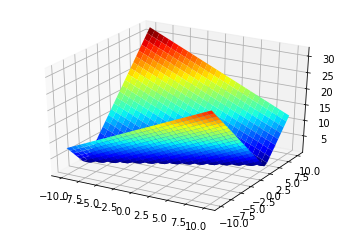

In [15]:
%matplotlib inline

x = np.outer(np.linspace(-10, 10, 30), np.ones(30))
y = x.copy().T
z = calculate_distance(x, y)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0);

The optimal values, i.e. those that make the if-condition true, have fitness value 0 and can be clearly seen at the bottom of the plot. The further away from the optimal values, the higher elevated the points in the search space.

### Instrumentation

The fitness function should calculate the distance value for concrete test executions. That is, we want to run the program, and then learn the distance value of this execution. However, the branching condition is hidden within the source code of the target function, and its value may in principle be the result of various calculations along the execution path reaching it. Even though in our example the condition is an equation using the input values of the function directly, this may not be the case in general; it might as well be derived values. Thus, the values we need to calculate our distance metric need to be observed directly at the conditional statement.

This is typically done with *instrumentation*: We add new code immediately before or after the branching condition to keep track of the values observed and calculate the distance using these values. The following is an instrumented version of our program under test, which prints out the distance values as it is executed:

In [16]:
def test_me_instrumented(x, y):
    print("Instrumentation: Input = (%d, %d), distance = %d" %
          (x, y, calculate_distance(x, y)))
    if x == 2 * (y + 1):
        return True
    else:
        return False

Let's try this out for a couple of example values:

In [17]:
test_me_instrumented(0, 0)

Instrumentation: Input = (0, 0), distance = 2


False

In [18]:
test_me_instrumented(5, 2)

Instrumentation: Input = (5, 2), distance = 1


False

In [19]:
test_me_instrumented(22, 10)

Instrumentation: Input = (22, 10), distance = 0


True

When calculating a fitness value, we will execute the instrumented program version, but we need some means to access the distance value calculated during that execution. As a simple first solution to this problem, we can just add a global variable and store the value of the distance calculation there. 

In [20]:
distance = 0

In [21]:
def test_me_instrumented(x, y):
    global distance
    distance = calculate_distance(x, y)
    if x == 2 * (y + 1):
        return True
    else:
        return False

Using this instrumented version of `test_me`, we can now finally define our fitness function, which simply runs the instrumented `test_me_instrumented` function, and then retrieves the value of the global `distance` variable:

In [22]:
def get_fitness(x, y):
    global distance
    test_me_instrumented(x, y)
    fitness = distance
    return fitness

Let's try this on some example inputs:

In [23]:
get_fitness(0, 0)

2

In [24]:
get_fitness(1, 2)

5

In [25]:
get_fitness(22, 10)

0

### Hillclimbing the example

Having decided on a representation (2-tuples of integers) and a fitness function (distance to target branch), we can now finally go ahead and implement our search algorithm. Let's explore this search space using the simplest possible meta-heuristic algorithm: Hillclimbing. The metaphor captures aptly what is happening: The algorithm tries to climb a hill in the search space defined by our representation. Except, that in our search landscape the best values are not those high up but down low, so technically we are are descending into valleys.

The hillclimbing algorithm itself is very simple: 
1. Take a random starting point
2. Determine fitness value of all neighbours
3. Move to neighbour with the best fitness value
4. If solution is not found, continue with step 2

The hillclimber starts with a random test input, i.e., random values for `x` and `y`. For any pair of random integer numbers, the chances of them satisfying the condition `x == 2 * (y + 1)` are rather slim. Suppose the random values are `(274, 153)`. The right hand side of the equation, `2 * (y + 1)`, evaluates to 308, so the condition is clearly false. Where should the hillclimber go to now? Let's look at the fitness values of this test input and its neighbours:

In [26]:
x, y = 274, 153
print("Origin %d, %d has fitness %d" % (x, y, get_fitness(x, y)))
for nx, ny in neighbours(x, y):
    print("Neighbour %d, %d has fitness %d" % (nx, ny, get_fitness(nx, ny)))

Origin 274, 153 has fitness 34
Neighbour 273, 152 has fitness 33
Neighbour 273, 153 has fitness 35
Neighbour 273, 154 has fitness 37
Neighbour 274, 152 has fitness 32
Neighbour 274, 154 has fitness 36
Neighbour 275, 152 has fitness 31
Neighbour 275, 153 has fitness 33
Neighbour 275, 154 has fitness 35


Increasing `y` by one increases the value of the right hand side of the equation to `310`. Thus, the value on the left hand side of the equation thus differs *even more* to the value on the right hand side of the equation than it did before the increase! So, increasing `y` does not seem like a good idea. On the other hand, increasing `x` by one improves things: The left hand side and the right hand side of the equation become more similar; they are "less unequal". Thus, out of the eight possible neighbors of `(274, 153)`, the neighbor that increases `x` and decreases `y` (`(275, 152)`) seems best intuitively --- the outcome of the condition is still false, but it is "less so" than for the original value.

Let's now implement the hillcimbing algorithm. 

In [27]:
import random

In [28]:
def hillclimber():
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = get_fitness(x, y)
    print("Initial value: %d, %d at fitness %.4f" % (x, y, fitness))
    iterations = 0

    # Stop once we have found an optimal solution
    while fitness > 0:
        iterations += 1
        # Move to first neighbour with a better fitness
        for (nextx, nexty) in neighbours(x, y):
            new_fitness = get_fitness(nextx, nexty)

            # Smaller fitness values are better
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                print("New value: %d, %d at fitness %.4f" % (x, y, fitness))
                break

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))

In [29]:
hillclimber()

Initial value: 201, -956 at fitness 2111.0000
New value: 200, -956 at fitness 2110.0000
New value: 199, -956 at fitness 2109.0000
New value: 198, -956 at fitness 2108.0000
New value: 197, -956 at fitness 2107.0000
New value: 196, -956 at fitness 2106.0000
New value: 195, -956 at fitness 2105.0000
New value: 194, -956 at fitness 2104.0000
New value: 193, -956 at fitness 2103.0000
New value: 192, -956 at fitness 2102.0000
New value: 191, -956 at fitness 2101.0000
New value: 190, -956 at fitness 2100.0000
New value: 189, -956 at fitness 2099.0000
New value: 188, -956 at fitness 2098.0000
New value: 187, -956 at fitness 2097.0000
New value: 186, -956 at fitness 2096.0000
New value: 185, -956 at fitness 2095.0000
New value: 184, -956 at fitness 2094.0000
New value: 183, -956 at fitness 2093.0000
New value: 182, -956 at fitness 2092.0000
New value: 181, -956 at fitness 2091.0000
New value: 180, -956 at fitness 2090.0000
New value: 179, -956 at fitness 2089.0000
New value: 178, -956 at fitnes

The hillclimber starts by choosing random values for `x` and `y`. We use low values in the range of `-1000`--`1000` (which we defined `MIN` and `MAX` to be earlier) to reduce the time search takes when playing with the example. Then, we determine the fitness value of this starting point by calling `get_fitness`. Recall that we are trying to find the smallest possible fitness value, therefore we now loop until we have found a fitness value of `0` (i.e., an optimal value). 

In this loop, we iterate over all neighbours (`neighbours`), and evaluate the fitness value of each of the neighbours. As soon as we have found a neighbour with better (smaller) fitness, the hillclimber exits the loop and uses this as the new starting point. An alternative variant of this simple hillclimbing algorithm would be to remove the `break` statement: By doing so, *all* neighbours would be evaluated and the best neighbour would be chosen. This is known as *steepest ascent hillclimbing*. You will see that the number of iterations necessary to reach the optimum is lower, although for each iteration more tests are executed.

In [30]:
def steepest_ascent_hillclimber():
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = get_fitness(x, y)
    print("Initial value: %d, %d at fitness %.4f" % (x, y, fitness))
    iterations = 0

    # Stop once we have found an optimal solution
    while fitness > 0:
        iterations += 1
        # Move to first neighbour with a better fitness
        for (nextx, nexty) in neighbours(x, y):
            new_fitness = get_fitness(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                print("New value: %d, %d at fitness %.4f" % (x, y, fitness))

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))

In [31]:
steepest_ascent_hillclimber()

Initial value: -258, 645 at fitness 1550.0000
New value: -259, 644 at fitness 1549.0000
New value: -258, 644 at fitness 1548.0000
New value: -257, 644 at fitness 1547.0000
New value: -258, 643 at fitness 1546.0000
New value: -257, 643 at fitness 1545.0000
New value: -256, 643 at fitness 1544.0000
New value: -257, 642 at fitness 1543.0000
New value: -256, 642 at fitness 1542.0000
New value: -255, 642 at fitness 1541.0000
New value: -256, 641 at fitness 1540.0000
New value: -255, 641 at fitness 1539.0000
New value: -254, 641 at fitness 1538.0000
New value: -255, 640 at fitness 1537.0000
New value: -254, 640 at fitness 1536.0000
New value: -253, 640 at fitness 1535.0000
New value: -254, 639 at fitness 1534.0000
New value: -253, 639 at fitness 1533.0000
New value: -252, 639 at fitness 1532.0000
New value: -253, 638 at fitness 1531.0000
New value: -252, 638 at fitness 1530.0000
New value: -251, 638 at fitness 1529.0000
New value: -252, 637 at fitness 1528.0000
New value: -251, 637 at fitnes

Our example program has a very nice fitness landscape --- there is a perfect gradient, and the hillclimber will always find a solution. We can see this nice gradient if we plot the fitness values observed over time:

In [32]:
def plotting_hillclimber(fitness_function):
    data = []

    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = fitness_function(x, y)
    data += [fitness]
    iterations = 0

    # Stop once we have found an optimal solution
    while fitness > 0:
        iterations += 1
        # Move to first neighbour with a better fitness
        for (nextx, nexty) in neighbours(x, y):
            new_fitness = fitness_function(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                data += [fitness]
                break

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    return data

In [33]:
data = plotting_hillclimber(get_fitness)

Found optimum after 429 iterations at -1000, -501


In [34]:
import matplotlib.pyplot as plt

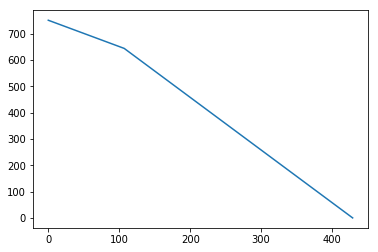

In [35]:
fig = plt.figure()
ax = plt.axes()

x = range(len(data))
ax.plot(x, data);

This gradient is the result of an ideal fitness landscape. In practice, we won't always have such a nice gradient. In particular, our hillclimber only works well as long as there is at least one neighbour that has a better fitness value. What if we reach a point where _none_ of the neighbours actually has a better fitness value? Consider the following function `test_me2`:

In [36]:
def test_me2(x, y):
    if(x * x == y * y * (x % 20)):
        return True
    else:
        return False

If we want to cover the true-branch of the if-condition in `test_me2` again, then we can calculate the distance in the same way as previously, i.e., by calculating the difference between the two sides of the comparison. Let's instrument the `test_me2` function:

In [37]:
def test_me2_instrumented(x, y):
    global distance
    distance = abs(x * x - y * y * (x % 20))
    if(x * x == y * y * (x % 20)):
        return True
    else:
        return False

With this instrumented version, we just need a fitness function that calls the instrumented version and reads out the global `distance` variable.

In [38]:
def bad_fitness(x, y):
    global distance
    test_me2_instrumented(x, y)
    fitness = distance
    return fitness

Before we run the hillclimber on this example, let's have a look at the search landscape again by plotting it:

In [39]:
from mpl_toolkits.mplot3d import Axes3D
from math import exp, tan

In [40]:
x = np.outer(np.linspace(-10, 10, 30), np.ones(30))
y = x.copy().T
z = abs(x * x - y * y * (x % 20))

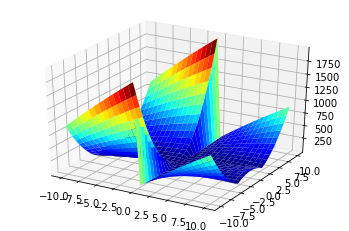

In [41]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0);

At this point it would be nice to run the hillclimber using the new fitness function, but there is a problem: Running our hillclimber with this fitness function is not a good idea, because it might never terminate. Suppose we've reached a point where all neighbours have the same or a worse fitness value. The hillclimber can move no where and is stuck there forever! Such a point in the search landscape is called a *local optimum*. If one reaches such a point, the easiest way out is to give up and restart from a new random point. This is what we will do in our hillclimber with *random restarts*. 

In [42]:
def restarting_hillclimber(fitness_function):
    data = []

    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = fitness_function(x, y)
    data += [fitness]
    print("Initial value: %d, %d at fitness %.4f" % (x, y, fitness))
    iterations = 0

    # Stop once we have found an optimal solution
    while fitness > 0:
        changed = False
        iterations += 1
        # Move to first neighbour with a better fitness
        for (nextx, nexty) in neighbours(x, y):
            new_fitness = fitness_function(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                data += [fitness]
                changed = True
                break
        if not changed:
            x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
            fitness = fitness_function(x, y)
            data += [fitness]

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    return data

The change is trivial: We simply keep track whether any movement has occurred with a boolean flag, and if we did not move to any of the neighbours, we pick a new random position to start over at. For convenience, we also made the hillclimber parameterizable with fitness functions. Let's try it out with our `bad_fitness` and plot the resulting fitness values we observe:

In [43]:
MAX = 1000
MIN = -MAX

In [44]:
data = restarting_hillclimber(bad_fitness)

Initial value: 333, 231 at fitness 582804.0000
Found optimum after 165 iterations at 521, 521


In [45]:
import matplotlib.pyplot as plt

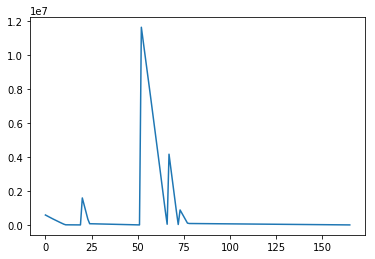

In [46]:
fig = plt.figure()
ax = plt.axes()

x = range(len(data))
ax.plot(x, data);

Run the example a couple of times. Sometimes, we are lucky and there is a gradient that takes is straight to an optimal solution. But sometimes you'll see restarts throughout the search before reaching an optimal value.

We restricted initial values of `x` and `y` to  rather small range of `[MIN, MAX]`. This is a common trick in test generation, as in *most* cases solutions tend to consist of small values, and using small values to start the search makes the search quicker in many cases. However, what if the solution we need is at a completely different place in our search space? Our bias towards smaller solutions would mean that the hillclimber would take very long to find the solution, and given a fixed search budget it would thus be less likely to actually find a solution. To see what effects this would have, we could simple replace the `1000` with, say, `1000000` or more. We can play around with the range to see the performance we get for our simple search problems.

In [47]:
MAX = 100000
MIN = -MAX

In [48]:
from Timer import Timer

In [49]:
with Timer() as t:
    restarting_hillclimber(get_fitness)
    print("Search time: %.2fs" % t.elapsed_time())

Initial value: 64543, -55357 at fitness 175255.0000
Found optimum after 169899 iterations at -100000, -50001
Search time: 0.90s


In most cases the search now will take much longer until a solution is found --- likely longer than we are prepared to wait for such a simple example function! (Although sometimes we will get lucky and randomly hit a good starting position). How is this ever going to work on "real" examples? Not to imagine if there were even more parameters and a bigger neighbourhood!

## Testing a More Complex Program

Let's turn to a slightly more complex program: The CGI decoder you already know from [the Coverage chapter](Coverage.ipynb). 

In [50]:
def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

### CGI Decoder as a Search Problem

The `cgi_decode` function has one input of type string, and one possible way to define the neighbourhood of a string is by all possible strings that have an edit distance of 1. For example, string `test` would have two neighbours for each of its four characters:

- `uest`
- `tfst`
- `tett`
- `tesu`
- `sest`
- `tdst`
- `tert`
- `tess`

In addition, prepending any character or appending any character would also have an edit distance of 1 and could be considered neighbours. To keep things simple, let's keep the length of our input strings fixed to a reasonable value (e.g. 10). In this case, each individual has 20 neighbours (i.e., each character has two neighbours).

Let's implement a new `neighbour_strings` function that produces these neighbouring strings:

In [51]:
def neighbour_strings(x):
    n = []
    for pos in range(len(x)):
        c = ord(x[pos])
        if c < 127:
            n += [x[:pos] + chr(c + 1) + x[pos + 1:]]
        if c > 20:
            n += [x[:pos] + chr(c - 1) + x[pos + 1:]]
    return n

The `neighbour_strings` function gets the numerical value of each character in the input string, and creates a new string with the character replaced with the preceding and succeeding characters in the alphabet. To start with, we only consider printable ASCII characters, which are in the range 20--127.

In [52]:
print(neighbour_strings("Hello"))

['Iello', 'Gello', 'Hfllo', 'Hdllo', 'Hemlo', 'Heklo', 'Helmo', 'Helko', 'Hellp', 'Helln']


Thus we have defined the search space for the `cgi_decode` function. The next ingredient to searching for individuals in this search space is a fitness function.

### Branch Distances

The `test_me` function consisted of a single if-condition, in which two integer numbers were compared. In the `cgi_decode` function we have three if-conditions and one while loop, and they all compare characters. Fortunately, as we have already seen, we can treat characters like numbers, so we can use the same distance estimate we used in the `test_me` example. However, there are also two conditions which check whether a character is contained in a set, e.g. `digit_high in hex_values`. How close is a value to being contained in the set? An obvious solution would be to consider the distance to the closest value in the set as the estimate.

In [53]:
import sys

In [54]:
def distance_character(target, values):

    # Initialize with very large value so that any comparison is better
    minimum = sys.maxsize

    for elem in values:
        distance = abs(target - elem)
        if distance < minimum:
            minimum = distance
    return minimum

In [55]:
distance_character(10, [1, 5, 12, 100])

2

In [56]:
distance_character(10, [0, 50, 80, 200])

10

A further simplification we have made so far was to assume that we would always want conditions to evaluate to true. In practice, we might want to have if-conditions evaluate to false just as well. Thus, each if-condition actually has two distance estimates, one to estimate how close it is to being true, and one how close it is to being false. If the condition is true, then the true distance is 0; if the condition is false, then the false distance is 0. That is, in a comparison `a == b`, if `a` is smaller than `b`, then the false distance of is `0` by definition. 

What is the distance of `a == b` being false when `a` equals `b`? Any change to either `a` or `b` would make the condition evaluate to false, so we can define the distance simply as 1 in this case.

More generally, there can be other types of comparisons, for example using relational operators. Consider the loop condition in `cgi_decode`: `i < len(s)`, i.e., it uses a less-than comparison operator. It is quite straight forward to extend our notion of branch distance to cover different types of comparisons, and to calculate true and false distances.  The following table shows how to calculate the distance for different types of comparisons:

| Condition | Distance True | Distance False |
| ------------- |:-------------:| -----:|
| a == b      | abs(a - b) | 1 |
| a != b      | 1          | abs(a - b) |
| a < b       | b - a + 1  | a - b      |
| a <= b      | b - a      | a - b + 1  |
| a > b       | a - b + 1  | b - a      |


Note that several of the calculations add a constant `1`. The reason for this is quite simple: Suppose we want to have `a < b` evaluate to true, and let `a = 27` and `b = 27`. The condition is not true, but simply taking the difference would give us a result of `0`. To avoid this, we have to add a constant value. It is not important whether this value is `1` -- any positive constant works.

### Dealing with Complex Conditions

In the `cgi_decode` function, we can also find a somewhat more complex predicate which consists of two conditions joined by a logical `and`:

`
if digit_high in hex_values and digit_low in hex_values:
`

In principle, the branch distance is defined such that the distance to make a conjunction `A and B` true equals the sum of the branch distances for `A` and `B`, as both of the two conditions would need to be true. Similarly, the branch distance to make `A or B` true would be the minimum of the two branch distances of `A` and `B`, as it suffices if one of the two conditions is true to make the entire expression true. 

However, it is not as easy as that in practice: Predicates can consist of nested conditions and negations, and one would need to convert the expression to canonical form before being able to apply this calculation. Furthermore, most modern programming languages use *short-circuit evaluation*: If there is a condition `A or B`, and `A` is true, then `B` is never evaluated. If `B` is an expression with side-effects, then by calculating the branch distance of `B` even though short-circuit evaluation would avoid its execution, we would potentially be changing the program behavior (by invoking the side-effect that would in normal behavior not be executed), and that is not acceptable.


Furthermore, what if the branching condition has side-effects? For example, suppose that the branching condition were `x == 2 * foo(y)`, where `foo` is a function that takes an integer as input. Naively instrumenting would lead to the following code:

```
    distance = abs(x - 2 * foo(y))
	if x == 2 * foo(y):
	...
```

Thus, the instrumentation would lead to `foo` being executed *twice*. Suppose `foo` changes the state of the system (e.g., by printing something, accessing the filesystem, changing some state variables, etc.), then clearly invoking `foo` a second time is a bad idea. One way to overcome this problem is to _transform_ the conditions, rather than _adding_ tracing calls. For example, one can create temporary variables that hold the values necessary for the distance calculation and then use these in the branching condition:

```
	tmp1 = x
	tmp2 = 2 * foo(y)
	distance = abs(tmp1 - tmp2)
	if tmp1 == tmp2:
	...
```

Besides these issues, the approach of adding a global variable and method call to the program seems like a rather clumsy approach --- surely we cannot start thinking about every branch in our program on its own and instrument the program we want to test manually, in particular if programs have multiple branches like the `cgi_decode` function. Rather, we should be looking at how to _automatically_ instrument programs to contain the necessary added statements such that we can calculate fitness values.

### Instrumentation for Atomic Conditions

An alternative approach to using the global and temporary variables is to replace the actual comparison with a call to a helper function, where the original expressions are evaluated as arguments, and the operator is an additional argument. Assume we have a function `evaluate_condition` which takes four parameters: `num` is a unique id that identifies the condition; `op` is the operator of the comparison; `lhs` and `rhs` are the operands. The function calculates two distances for the condition: The distance to the condition evaluating to true, and the distance to the condition evaluating to false. One of the two outcomes will always be true, and thus one of them will always have distance `0`. Since the function replaces the original comparison, it returns true or false, depending on which distance is `0`. That means, the example expression 

```
    if x == 2 * foo(y)
```
    
would be replaced by 

```
    if evaluate_condition(0, "Eq", x, 2 * foo(y))
```

such that the arguments are only evaluated once, and side-effects are thus handled correctly. Here is how the `evaluate_condition` function looks like:


In [57]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true = 0
    distance_false = 0
    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    # ... code for other types of conditions

    if distance_true == 0:
        return True
    else:
        return False

Note that we are initializing `distance_true` and `distance_false` with `0`. Thus, if `lhs` equals `rhs`, then the variable `distance_true` remains 0, and vice versa.

In [58]:
evaluate_condition(1, "Eq", 10, 20)

False

In [59]:
evaluate_condition(2, "Eq", 20, 20)

True

What the `evaluate_condition` function does not yet do is store the distances observed. Obviously, we will need to store the values somewhere so that we can access it from our fitness function. Since the `cgi_decode` program consists of several conditions, and for each condition we might be interested in the true and the false distance, we simply use two global dictionaries, `distances_true` and `distances_false`, and define a helper function that stores the distance values observed in the dictionary:

In [60]:
def update_maps(condition_num, d_true, d_false):
    global distances_true, distances_false

    if condition_num in distances_true.keys():
        distances_true[condition_num] = min(
            distances_true[condition_num], d_true)
    else:
        distances_true[condition_num] = d_true

    if condition_num in distances_false.keys():
        distances_false[condition_num] = min(
            distances_false[condition_num], d_false)
    else:
        distances_false[condition_num] = d_false

The variable `condition_num` is the unique ID of the condition that we've just evaluated. If this is the first time that we have executed this particular condition, then the true and false distances are simply stored in the corresponding dictionaries. However, it is possible that the same test executions a condition multiple times. For example, the loop condition `i < len(s)` in the `cgi_decode` function is evaluated before every single loop iteration. In the end, however, we want to have a single fitness value for a test. As covering a branch just requires that at least one of the executions reaches the branch, we consider only the closest one. Therefore, if the `distances_true` and `distances_false` dictionaries already contain the distance from a previous execution, we only replace that value if the new execution was closer to reaching the branch; this is implemented using the `min` functions.

We now need to call this function from within `evaluate_condition`. Let's also add the calculation of distance for the `in` operator and the `<` comparison, since we need both of them for the `cgi_decode` example. Furthermore, `cgi_decode` actually compares characters and numbers. To make sure we use the correct types, we first have to convert the characters to numbers to calculate the distances. This is done using Python's `ord` function.

In [61]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true = 0
    distance_false = 0

    # Make sure the distance can be calculated on number and character
    # comparisons
    if isinstance(lhs, str):
        lhs = ord(lhs)
    if isinstance(rhs, str):
        rhs = ord(rhs)

    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    elif op == "Lt":
        if lhs < rhs:
            distance_false = rhs - lhs
        else:
            distance_true = lhs - rhs + 1
    # ...
    # handle other comparison operators
    # ...

    elif op == "In":
        minimum = sys.maxsize
        for elem in rhs.keys():
            distance = abs(lhs - ord(elem))
            if distance < minimum:
                minimum = distance

        distance_true = minimum
        if distance_true == 0:
            distance_false = 1

    update_maps(num, distance_true, distance_false)

    if distance_true == 0:
        return True
    else:
        return False

The following shows the instrumentation of the conjunction from `cgi_decode` to make use of the `evaluate_condition` function. There are two calls to `evaluate_condition` corresponding to the two conditions, and the `and` with which they are conjoined ensures that the original short-circuiting behavior is preserved:

`
if (evaluate_condition(4, 'In', digit_high, hex_values) and evaluate_condition(5, 'In', digit_low, hex_values))
`

Of course we would like to automatically produce this instrumented varion.

### Instrumenting Source Code Automatically

Replacing comparisons automatically is actually quite easy in Python, using the abstract syntax tree (AST) of the program. In the AST, a comparison will typically be a tree node with an operator attribute and two children for the left-hand and right-hand operators. To replace such comparisons with a call to `evaluate_condition` one simply needs to replace the comparison node in the AST with a function call node, and this is what the `BranchTransformer` class does using a NodeTransformer from Python's `ast` module:


In [62]:
import ast

In [63]:
class BranchTransformer(ast.NodeTransformer):

    branch_num = 0

    def visit_FunctionDef(self, node):
        node.name = node.name + "_instrumented"
        return self.generic_visit(node)

    def visit_Compare(self, node):
        if node.ops[0] in [ast.Is, ast.IsNot, ast.In, ast.NotIn]:
            return node

        self.branch_num += 1
        return ast.Call(func=ast.Name("evaluate_condition", ast.Load()),
                        args=[ast.Num(self.branch_num),
                              ast.Str(node.ops[0].__class__.__name__),
                              node.left,
                              node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

The `BranchTransformer` parses a target Python program using the built-in parser `ast.parse`, which returns the AST. Python provides API to traverse and modify this AST. To replace the comparison with a function call we use an `ast.NodeTransformer`, which uses the visitor pattern where there is one `visit_*` function for each type of node in the AST. As we are interested in replacing comparisons, we override `visit_Compare`, where instead of the original comparison node we return a new node of type `ast.Func`, which is a function call node. The first parameter of this node is the name of the function `evaluate_condition`, and the arguments are the four arguments that our `evaluate_condition` function expects: Number of branch (for which we keep a count in `branch_num`), the operator (for which we simply use the class name), the left-hand side, and the right-hand side. Note that Python allows comparisons of multiple expressions (e.g. `1 < x < 10`); to keep the code simple we only deal with individual comparisons here, but it would be straight forward to extend the code by treating each comparison with an individual call to `evaluate_condition`. You will notice that we also override `visit_FunctionDef`; this is just to change the name of the method by appending `_instrumented`, so that we can continue to use the original function together with the instrumented one.

The following code parses the source code of the `cgi_decode` function to an AST, then transforms it, and prints it out again (using the `to_source` function from the `astor` library):

In [64]:
import inspect
import ast
from astor import to_source

In [65]:
source = inspect.getsource(cgi_decode)
node = ast.parse(source)
BranchTransformer().visit(node)

# Make sure the line numbers are ok before printing
node = ast.fix_missing_locations(node)
print(to_source(node))

def cgi_decode_instrumented(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""
    hex_values = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6,
        '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14,
        'f': 15, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15}
    t = ''
    i = 0
    while evaluate_condition(1, 'Lt', i, len(s)):
        c = s[i]
        if evaluate_condition(2, 'Eq', c, '+'):
            t += ' '
        elif evaluate_condition(3, 'Eq', c, '%'):
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if evaluate_condition(4, 'In', digit_high, hex_values
                ) and evaluate_condition(5, 'In', digit_low, hex_values):
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:


To calculate a fitness value with the instrumented version, we need to compile the instrumented AST again, which is done using Python's `compile` function. We then need to make the compiled function accessible, for which first retrieve the current module from `sys.modules`, and then add the compiled code of the instrumented function to the list of functions of the current module using `exec`. After this, the `cgi_decode_instrumented` function can be accessed.

In [66]:
def create_instrumented_function(f):
    source = inspect.getsource(f)
    node = ast.parse(source)
    node = BranchTransformer().visit(node)

    # Make sure the line numbers are ok so that it compiles
    node = ast.fix_missing_locations(node)

    # Compile and add the instrumented function to the current module
    current_module = sys.modules[__name__]
    code = compile(node, filename="<ast>", mode="exec")
    exec(code, current_module.__dict__)

In [67]:
# Set up the global maps
distances_true = {}
distances_false = {}

In [68]:
# Create instrumented function
# cgi_decode_instrumented = 
create_instrumented_function(cgi_decode)

In [69]:
assert cgi_decode("Hello+Reader") == cgi_decode_instrumented("Hello+Reader")

In [70]:
cgi_decode_instrumented("Hello+Reader")

'Hello Reader'

In [71]:
distances_true

{1: 0, 2: 0, 3: 35}

In [72]:
distances_false

{1: 0, 2: 0, 3: 0}

As we can see from the `distances_true` and `distances_false` maps, conditions 1 and 2 have evaluated to true and to false, whereas condition 3 has only evaluated to false, when executed on `cgi_decode_instrumented`. This is as expected, since the while-loop was entered and left, and there was one white space but no `%`-character in the input string.

### Fitness Function to Create Valid Hexadecimal Inputs

As an example, let's take as objective to test the part of `cgi_decode` that decodes valid hexadecimal codes. This means that we want to make condition 1 true, 2 false, 3 true, and 4 true. To represent such a path, we can simply sum up the branch distances for exactly these branches. However, there is a potential issue with simply summing up branch distances: If the distance for one condition depends on a comparison of very large values and the distance calculation for another condition depends on small values, then an improvement of the large values would very likely lead to a better fitness improvement, and thus bias the search. To avoid this, we need to *normalize* branch distances before adding them up.

A normalisation function for a range `[a, b]` takes a number as input and returns a value that is `>=a` and `<=b`. The important thing about the function is that for any two numbers `x` and `y` the ordering needs to be preserved by the normalisation. That is, if `x<y` then it must also hold that `normalize(x) < normalize(y)`. There are many different functions that could achieve this result; a simple one is `normalize(x) = x/(x+k)`: It is computationally cheap, and will normalise any positive value in the range `[0,1]` (to change this to `[0,b]` one would just need to multiply by `b`). If we use this normalisation function, we also know the maximum value: it is `1.0`. The function assumes that the value to be normalised is positive. The value of the factor `k` defines the steepness of the curve. For example, for `k=1` (which is a good default value) the curve is very steep, with values quickly approaching, but never reaching, `1`.

In [73]:
def normalize(x):
    return x / (1.0 + x)

To see how this normalisation function works, we can plot a range of values. The x-axis contains the original values, the y-axis shows the corresponding normalised value:

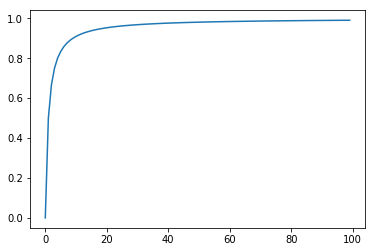

In [74]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()

x = range(100)
y = [value / (value + 1.0) for value in x]
ax.plot(x, y);

Using this normalization function, we can calculate a fitness value by running the instrumented program under test, and then adding up the normalized values of the relevant branches. However, not every if statement will be executed by every test case. What is the branch distance for a branch that wasn't even executed? We need to make sure that the branch distance for branches that weren't even executed is higher than any of the branch distances observed during execution. Given our normalization, we know this maximum value is 1. Thus, the fitness function could look like this:

In [75]:
def get_fitness(x):
    # Reset any distance values from previous executions
    global distances_true, distances_false
    distances_true = {}
    distances_false = {}

    # Run the function under test
    try:
        cgi_decode_instrumented(x)
    except BaseException:
        pass

    # Sum up branch distances
    fitness = 0.0
    for branch in [1, 3, 4, 5]:
        if branch in distances_true:
            fitness += normalize(distances_true[branch])
        else:
            fitness += 1.0

    for branch in [2]:
        if branch in distances_false:
            fitness += normalize(distances_false[branch])
        else:
            fitness += 1.0

    return fitness

To see our instrumentation in action, let's calculate fitness values for a couple of example inputs, progressively getting closer to the target.

In [76]:
# Empty string does not even enter the loop
get_fitness("")

4.5

In [77]:
# String contains no percentage character
get_fitness("Hello+Reader")

2.9722222222222223

In [78]:
# String contains a percentage character, but no valid hex char
get_fitness("%UU")

1.9230769230769231

In [79]:
# String contains a percentage character, but only one valid hex char
get_fitness("%AU")

0.9230769230769231

In [80]:
# String contains a percentage character and two valid hex chars
get_fitness("%AA")

0.0

### Hillclimbing Valid Hexadecimal Inputs

We have now defined the search space through our `neighbour_strings` function, and we have derived a new fitness function, so before we can apply the hillclimber to the problem of finding strings that contain valid 2-digit hex codes, the only remaining point is to derive a random starting point, which you've already done previously in the [MutationFuzzer chapter](MutationFuzzer.ipynb):

In [81]:
def random_string(l):
    s = ""
    for i in range(l):
        random_character = chr(random.randrange(32, 127))
        s = s + random_character
    return s

Now we can put it all together and use the identical hillclimbing algorithm again, and just make it generate random strings instead of numbers, and use the new fitness function:

In [82]:
def hillclimb_cgi():
    x = random_string(10)
    fitness = get_fitness(x)
    print("Initial input: %s at fitness %.4f" % (x, fitness))

    while fitness > 0:
        changed = False
        for (nextx) in neighbour_strings(x):
            new_fitness = get_fitness(nextx)
            if new_fitness < fitness:
                x = nextx
                fitness = new_fitness
                changed = True
                print("New value: %s at fitness %.4f" % (x, fitness))
                break

        # Random restart if necessary
        if not changed:
            x = random_string(10)
            fitness = get_fitness(x)

    print("Optimum at %s, fitness %.4f" % (x, fitness))

In [83]:
hillclimb_cgi()

Initial input: o'@[3(rW*M at fitness 2.6667
New value: o&@[3(rW*M at fitness 2.5000
New value: o%@[3(rW*M at fitness 1.5000
New value: o%A[3(rW*M at fitness 0.8571
New value: o%A\3(rW*M at fitness 0.8333
New value: o%A]3(rW*M at fitness 0.8000
New value: o%A^3(rW*M at fitness 0.7500
New value: o%A_3(rW*M at fitness 0.6667
New value: o%A`3(rW*M at fitness 0.5000
New value: o%Aa3(rW*M at fitness 0.0000
Optimum at o%Aa3(rW*M, fitness 0.0000


Run the hillclimber a couple of times to see it generate strings with valid hex characters. Sometimes it only takes a couple of steps, sometimes it takes longer, but at the end it always solves the problem and generates the string we want to have.

## Evolutionary Search

Hillclimbing works well, if the neighbourhood is reasonably small. This was the case so far in the `cgi_decode` example because we limited ourselves to a fixed number of characters (10) and limited the character range to printable ASCII characters. But imagine what happens if we are not looking for ASCII characters, but  UTF-16 unicode characters? These are not allowed in URLs really, but let's see what happens if we change our search space:

In [84]:
def random_unicode_string(l):
    s = ""
    for i in range(l):
        # Limits to reflect range of UTF-16
        random_character = chr(random.randrange(0, 65536))
        s = s + random_character
    return s

In [85]:
def unicode_string_neighbours(x):
    n = []
    for pos in range(len(x)):
        c = ord(x[pos])
        # Limits to reflect range of UTF-16
        if c < 65536:
            n += [x[:pos] + chr(c + 1) + x[pos + 1:]]
        if c > 0:
            n += [x[:pos] + chr(c - 1) + x[pos + 1:]]

    return n

UTF-8 characters are represented with 16 bits, and this gives us a range of 65536 possible characters. The functions above are adapted to these boundaries. Before we run the hillclimber again, let's make one more change: We will add an iteration limit so that we can give up the search, rather than waiting forever for it to complete.

In [86]:
def terminal_repr(s):
    return terminal_escape(repr(s))

In [87]:
def hillclimb_cgi_limited(max_iterations):
    x = random_unicode_string(10)
    fitness = get_fitness(x)
    print("Initial input: %s at fitness %.4f" % (terminal_repr(x), fitness))

    iteration = 0
    while fitness > 0 and iteration < max_iterations:
        changed = False
        for (nextx) in unicode_string_neighbours(x):
            new_fitness = get_fitness(nextx)
            if new_fitness < fitness:
                x = nextx
                fitness = new_fitness
                changed = True
                print("New value: %s at fitness %.4f" %
                      (terminal_repr(x), fitness))
                break

        # Random restart if necessary
        if not changed:
            x = random_string(10)
            fitness = get_fitness(x)
        iteration += 1

    print("Optimum at %s, fitness %.4f" % (terminal_repr(x), fitness))

In [88]:
hillclimb_cgi_limited(100)

Initial input: '埂\udf19\uf67c듵騛쁥핡勸\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勷\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勶\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勵\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勴\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勳\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勲\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勱\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勰\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勯\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勮\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勭\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勬\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勫\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勪\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勩\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛쁥핡勨\uf172싕' at fitness 3.0000
New value: '埂\udf19\uf67c듵騛

You can play around with the iteration limit and see how long it takes to find a solution in this search space. Unless you are lucky with the random starting point, this usually takes really unreasonably long.

### Global Search

The hillclimber explores the local neighbourhood of an individual in each step of the search, and if the neighbourhood is too large, then this takes too long. An alternative strategy is to not restrict the search to the local neighbourhood, but to search the search space *globally*. That is, the search algorithm is allowed to make larger steps around the search space. A simple modification of the hillclimber converts it from a local to a global search algorithm: Instead of looking at all the immediate neighbours, the individual is *mutated* in a way that allows larger modifications.

A *mutation* is a change that represents such a larger step around the search space. An important decision when implementing a mutation is that it should, theoretically, be possible to reach any point in the search space simply by applying mutation successively. However, mutation usually should not completely replace an individual with a random one. It is important for the search to be effective that the mutation constitutes a reasonable change to an individual that still maintains most of its traits. For our search problem of 10-character strings, a possible mutation would be to replace only _1_ out of the 10 characters, as follows:

In [89]:
def flip_random_character(s):
    pos = random.randint(0, len(s) - 1)
    new_c = chr(random.randrange(0, 65536))
    return s[:pos] + new_c + s[pos + 1:]

A simple modification of the hillclimber is to replace the exploration of the neighbourhood with mutations. In each iteration, the current individual is mutated. The resulting offspring individual is compared to its parent, and the better of the two is the new point in the search space, and used for the next iteration of mutation. This is called "randomized hillclimbing".

In [90]:
def randomized_hillclimb():
    x = random_unicode_string(10)
    fitness = get_fitness(x)
    print("Initial value: %s at fitness %.4f" %
          (terminal_repr(x), fitness))

    iterations = 0
    while fitness > 0:
        mutated = flip_random_character(x)
        new_fitness = get_fitness(mutated)
        if new_fitness <= fitness:
            x = mutated
            fitness = new_fitness
            #print("New value: %s at fitness %.4f" %(terminal_repr(x), fitness))
        iterations += 1

    print("Optimum at %s after %d iterations" %
          (terminal_repr(x), iterations))

In [91]:
randomized_hillclimb()

Initial value: '舨ᑆ\uec4f\ue27f羏\uf314䖗繣厪킨' at fitness 2.9998
Optimum at 'ጤ〆撟%e5匸㗵暠ᴌ' after 34356 iterations


This algorithm usually finds the solution quicker than the standard hillclimber, although it is still rather slow! 

There is one subtle, but crucial, change between the hillclimber and the randomized version that is worth pointing out: Note the comparison `new_fitness <= fitness`, whereas in the hillclimber we used `new_fitness < fitness`. This is important because the search landscape may have areas with equal fitness values (plateaus) which we somehow need to overcome. In the standard hillcimber we did this with random restarts. If the randomized hillclimber would reject offspring with identical fitness, it would keep mutating the identical individual, and possibly struggle to escape the plateau. If we replace also with equal fitness, we allow the search to move around the plateau, increasing chances of escaping it eventually.


The randomized hillclimber is also known as *1+1 Evolutionary Algorithm* (*(1+1)EA*). An evolutionary algorithm is a meta-heuristic search algorithm that tries to mimic the natural processes of evolution. Natural evolution is based
on populations where environmental pressure causes natural selection: Only the fittest survive, while those that are not fit enough will die, and thus the overall fitness of the population gradually improves. The (1+1)EA is a very specific evolutionary algorithm with a population size of 1, which produces exactly 1 offspring. However, the most common search algorithm in practice is a genetic algorithm.

### Genetic Algorithms

One of the best known evolutionary algorithms is the *Genetic Algorithm* (GA). A GA is based on the idea that problem solutions can be genetically encoded: A chromosome consists of a sequence of genes, where each gene encodes one trait of the individual (e.g., eye colour, hair colour, etc.). A fitness function can take the information contained in this description, the so called genotype, and evaluates the properties of the resulting phenotype, i.e., the actual solution represented by this genetic encoding. The fitness value of an individual is measured on the phenotype.

For our `cgi_decode` example, we could consider individual characters to be the genes, and then a chromosome is a sequences of characters. In other words, the genetic encoding is exactly what we already used so far! However, for the GA the representation requires different operations than the enumeration of the neighbourhood.

The GA emulates natural evolution with the following process:

- Create an initial population of random chromosomes
- Select fit individuals for reproduction
- Generate new population through reproduction of selected individuals
- Continue doing so until an optimal solution has been found, or some other limit has been reached.

The first step, creating an initial population, is trivial:

In [92]:
def create_population(size):
    return [random_unicode_string(10) for i in range(size)]

In [93]:
create_population(10)

['㛇莜戹豔㮝\ue008力ᒐᱯꊎ',
 '\ue295쁉陵ꯃ赖蟽⍬꺲緥㲱',
 '\u2e77騬⊳铁땕\uf189\ue663쌯幆艆',
 '龚筓\uf3a9욀놷䓒隯迌쀐∑',
 '쓛唁뗌蹽\udcd5偏躝娒鸭赌',
 '蹤⪖ឺ웳ఫ䓻䤷溸ᰒﵘ',
 '㲒혋Ꮘ\uea95\udf7b䢶裕㖬눹庑',
 '\u2d9d鼓咝笩窻ꨔ铺扄\ueb57\uf1bf',
 '\udd26Ч甄ꃢ\udcb0㼁튰㣋ช봼',
 '닇軬欴鞛㈓Ẫ住畿ꔪ칀']

The selection process prefers fitter individuals, therefore we need to determine the fitness values for all the individuals in our population. As we are going to need the fitness value for each individual at several places in the algorithm, we are going to store it by making fitness a list of _tuples_, each tuple consisting of an individual and its fitness value.

In [94]:
def evaluate_population(population):
    fitness = [get_fitness(x) for x in population]
    return list(zip(population, fitness))

In [95]:
population = create_population(10)

In [96]:
for (individual, fitness) in evaluate_population(population):
    print("%s: %.4f" % (terminal_repr(individual), fitness))

'\ue46fت팣㘇ธ漅ೇ↪䜭㎮': 2.9994
'\ua7e9\ue9e0\ue7de턤댪囿厠‐\ue0c5ﴌ': 2.9999
'䇯Ꜩ잣\ua9ce㙦\uf4aa歿蘸ཎ㫜': 2.9997
'ⱳ콾哇\uef1f\uf6a8⾃䣖坤Ꮾ둰': 2.9998
'າ伫螉\ue110㝎겱괼䆵喞\u18ac': 2.9997
'ས婎쥤䇉韤\udd06䕮춵磒露': 2.9997
'辺緢噑粲\uf400嚳寬\x87ꐂ쑹': 2.9899
'뉫㻑\u1fd4㈖鬒樼\u0dcc朏\ue57eማ': 2.9997
'얨㐁皭់멄\ud97b\ueac9㢂ቅ뮜': 2.9998
'⒃⍜㈪㊷\udbdb乑蓍\udc48鱲뻜': 2.9999


The use of a fitness value in the search is typically explained using "survival of the fittest", but one of Darwin’s key insights on evolution was that selection is not only defined by survival -- individuals reproduce sexually, and sexual selection describes the selection pressure during reproduction. This selection is typically influenced by either combat: rivalling males fighting over a female, and the stronger (fitter) male wins; the selection is also influenced by display. Darwin’s example for this is the peacock: The peacock has long, beautiful tail feathers that appear to serve no purpose, and do not seem to support the concept of natural selection. However, peahens are influenced in their selection of a sexual partner by his appearance. Impressive ornaments suggest that a male is genetically particularly healthy and will lead to healthy offspring. This is reflected in a GA: The better the fitness value an individual, the more likely it is to mate with another individual. A simple selection algorithm that reflects this concept is *tournament selection*: A small number of randomly chosen individual compete to be selected, and the best is selected:

In [97]:
def selection(evaluated_population, tournament_size):
    competition = random.sample(evaluated_population, tournament_size)
    winner = min(competition, key=lambda individual: individual[1])[0]

    # Return a copy of the selected individual
    return winner[:]

The `tournament_size` parameter specifies how many randomly selected individuals out of the population participate in the tournament. This is an important choice as it determines *selective pressure*: The larger the tournament size, the larger the probability of very good individuals being included in the tournament. This, in turn, increases the probability of these very good individuals of dominating the next generation, thus reducing the diversity and leading to premature convergence. In contrast, if the tournament size is too small, then this inhibits evolution. The best value for the tournament size depends on the population size, but usually it is fairly small (e.g. 5). Let's run a tournament using all individuals of an example population to see that the best one is selected:

In [98]:
population = create_population(10)
fitness = evaluate_population(population)
selected = selection(fitness, 10)

In [99]:
for (individual, fitness_value) in fitness:
    print("%s: %.4f" % (terminal_repr(individual), fitness_value))

'둚䘣蹸붢騒ꋎỺ觉\ued2a焊': 2.9999
'닔㶐ꡡ\udca4贕굇᳆\ueccd윘赉': 2.9999
'笁깉ရ豴\uea60ᛰ滒鶵）Ⰴ': 2.9998
'㠒㵄\ue14cᤃᇚ\udebe\uf851쿛鏆闊': 2.9998
'ࠝ\udd53ᶂ㮍訬廘랦铘뫘출': 2.9995
'ꡩၔ玤姨乪药汏䗫汔悔': 2.9998
'\uef2a潦ﳠ鹉卼㴐Ṭ\uf4b0˅얓': 2.9985
'❱\u0ff7╇塐䲫琭煸ᮤឋ퇃': 2.9998
'ڮ焈㱉煉ꅿᦗ툍혐خ꧓': 2.9994
'ἂጋ\uddcc\ue3d7粖\ude2c⮌鮓讃\ueab6': 2.9998


In [100]:
print("Winner: %s" % terminal_repr(selected))

Winner: '\uef2a潦ﳠ鹉卼㴐Ṭ\uf4b0˅얓'


Like in natural evolution, the individuals selected based on their fitness reproduce, to form a new generation. During this reproduction, like in natural reproduction, genetic material of the selected parents is combined. This is typically done by a process known as *crossover*, where an offspring chromosome is produced from the genes of its parents. In our case, a chromosome is a sequence of characters, and crossing over two parent sequences of characters can simply be done by chosing a cutoff random point, and creating offspring by combining the halves of the parents chromosomes based on the cutoff point.

In [101]:
def crossover(parent1, parent2):
    pos = random.randint(1, len(parent1))

    offspring1 = parent1[:pos] + parent2[pos:]
    offspring2 = parent2[:pos] + parent1[pos:]

    return (offspring1, offspring2)

In [102]:
parent1 = "Hello World"
parent2 = "Goodbye Book"

crossover(parent1, parent2)

('Hello W Book', 'Goodbyeorld')

A further essential ingredient of genetic evolution is the concept of mutation: Sometimes, offspring contain small changes in their genes, which represent new genetic material and new physiological traits. If the mutation introduced new genetic material that represents useful traits leading to better fitness values, then this genetic material will survive. If the mutation introduced useless genetic material, then the resulting individuals will likely have bad fitness values and die off quickly.

An important aspect is that both, mutation and crossover, are probabilistic actions. They do not always happen, and their effects are different every time they do happen. For a sequence genetic encoding, a common approach is to first use a probability to decide whether to apply mutation, and then to select one gene and change it a bit. Alternatively, we can probabilistically mutate genes such that on average one is changed. We do this by calculating a probability `P` of each gene being mutated as 1/(number of genes). Then, if a gene is mutated, we don't just replace it by a random character, but make it more likely that there is only a small change. This is achieved by sampling from a Gaussian distribution with the current value as the mean. We arbitrarily use a standard deviation of 100 to make small changes more likely than large changes.

In [103]:
def mutate(chromosome):
    mutated = chromosome[:]
    P = 1.0 / len(mutated)

    for pos in range(len(mutated)):
        if random.random() < P:
            new_c = chr(int(random.gauss(ord(mutated[pos]), 100) % 65536))
            mutated = mutated[:pos] + new_c + mutated[pos + 1:]
    return mutated

Now at last we have all the ingredients to build the full algorithm:

In [104]:
def genetic_algorithm():
    # Generate and evaluate initial population
    generation = 0
    population = create_population(100)
    fitness = evaluate_population(population)
    best = min(fitness, key=lambda item: item[1])
    best_individual = best[0]
    best_fitness = best[1]
    print("Best fitness of initial population: %s - %.10f" %
        (terminal_repr(best_individual), best_fitness))

    # Stop when optimum found, or we run out of patience
    while best_fitness > 0 and generation < 1000:

        # The next generation will have the same size as the current one
        new_population = []
        while len(new_population) < len(population):
            # Selection
            offspring1 = selection(fitness, 10)
            offspring2 = selection(fitness, 10)

            # Crossover
            if random.random() < 0.7:
                (offspring1, offspring2) = crossover(offspring1, offspring2)

            # Mutation
            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)

            new_population.append(offspring1)
            new_population.append(offspring2)

        # Once full, the new population replaces the old one
        generation += 1
        population = new_population
        fitness = evaluate_population(population)

        best = min(fitness, key=lambda item: item[1])
        best_individual = best[0]
        best_fitness = best[1]
        print(
            "Best fitness at generation %d: %s - %.8f" %
            (generation, terminal_repr(best_individual), best_fitness))

    print(
        "Best individual: %s, fitness %.10f" %
        (terminal_repr(best_individual), best_fitness))

Let's see how this works on our unicode example.

In [105]:
genetic_algorithm()

Best fitness of initial population: '俴\x8a辰燄펧䬍缯檒㤢⦡' - 2.9901960784
Best fitness at generation 1: 'ཬə쫯ὼ酟剺鬈{Ż\ue313' - 2.98850575
Best fitness at generation 2: '俴\x82辰燄酟剺鬢\x1bŻ\ue313' - 2.90909091
Best fitness at generation 3: 'ྂɵ쫕ὼ酟剺鬈%Ŧ\ue384' - 1.99610895
Best fitness at generation 4: 'ྂɵ쬆ὼ酟剺鬈%ŋ\ue384' - 1.99565217
Best fitness at generation 5: '俴ʐ쫕ἶ酟剺髺%¼\ue384' - 1.98850575
Best fitness at generation 6: 'ྂɵ쫪ὼ酟剒鬈%\x9e\ue37f' - 1.98245614
Best fitness at generation 7: '俴̗쪕ἶ酟剺髱%4\ue378' - 0.99998280
Best fitness at generation 8: '侪\x86쪕ἶ酟剺髱%4\ue378' - 0.99998280
Best fitness at generation 9: '俆ǫ쪸ἶ醿剺髱%4\ue2b5' - 0.99998274
Best fitness at generation 10: '俆ǫ쪸ἶ釘剺髧%4\ue2b5' - 0.99998274
Best fitness at generation 11: '俆ɫ쫕Ồ酟剺髱%4\ue256' - 0.99998271
Best fitness at generation 12: '侪\x86쪕ἶ醿剺髱%4\ue1f9' - 0.99998268
Best fitness at generation 13: '侪ï쪕ἶ醿剺髱%4\ue1f9' - 0.99998268
Best fitness at generation 14: '俆\x86쪕ἶ醿剺髱%4\ue1f9' - 0.99998268
Best fitness at generation 15: '俆Ǩ쪸ἂ醿剺髱%4\ue150' - 0.999

## Lessons Learned

* A meta-heuristic search problem consists of an algorithm, a representation, and a fitness function.
* For test generation, fitness functions typically estimate how close an execution comes to a target location. To determine this distance, we use instrumentation to calculate the distance during test execution.
* Local search algorithms like hillcimbing work well when the neighbourhood is well defined and not too large.
* Global search algorithms like genetic algorithms are very flexible and scale up well to larger test problems.

## Next Steps

In this chapter we looked at rather simple program inputs. We can apply the same search algorithms also to evolve complex test inputs

* [e.g. for web fuzzing](WebFuzzer.ipynb)

## Background

The targets of the search are typically related to coverage. For discussions, see the books in the [Introduction to Testing](Intro_Testing.ipynb).

**Solution.** _Some text for the solution_

In [106]:
# def hillclimber():
#     # Create and evaluate starting point
#     x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
#     fitness = get_fitness(x, y)
#     print("Initial value: %d, %d at fitness %.4f" % (x, y, fitness))
#     iterations = 0

#     # Stop once we have found an optimal solution
#     while fitness > 0:
#         iterations += 1
#         # Move to first neighbour with a better fitness
#         for (nextx, nexty) in neighbours(x, y):
#             new_fitness = get_fitness(nextx, nexty)
#             if new_fitness < fitness:
#                 x, y = nextx, nexty
#                 fitness = new_fitness
#                 changed = True
#                 print("New value: %d, %d at fitness %.4f" % (x, y, fitness))
#                 break

#     print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))

In [107]:
# hillclimber()

_Some more text for the solution_